# Credit Card Fraud Detection

## Introduction

The aim of this project is to kickstart my understanding of fraud detection used by credit card companies. I am especially interested in learning how to handle imbalanced datasets as this will be a valuable skill to apply on future problems that I plan on tackling. 

## 1.1 About the Dataset

The datasets contains credit card transactions made by European cardholders over two days in September 2013. The dataset is highly imbalanced, with fraud transactions (positive class) that account for only 0.17% of all transactions. There are 492 frauds out of 284,807 transactions.

The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. 

The dataset has already gone through some preprocessing before it was released to the public:
- It contains only numerical input variables that are the result of a PCA transformation.
- Due to confidentiality issues, the original features and background information about the data are unavailable. 

## 1.2 Initial look at the dataset

We first need to open up the dataset and check that it is the expected file and not something else. It is important to split the data into a training and test set before an exploratory data analysis is carried out to prevent information leak. Therefore this is just a cursory examination of the data. 

In [1]:
import pandas as pd
import numpy as np 
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

import datetime
import time

In [2]:
df = pd.read_csv("C:/input/creditcard.csv")

In [3]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The authors of this dataset supplied some additional information for data scientists:
- Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.
- Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. 
- Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. 
- The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. 

In [5]:
df.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


In [6]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [7]:
df.isnull().sum().max()

0

There are No Null Values. This is a good!

In [8]:
print ("Fraud transactions")
print (df.Time[df.Class == 1].describe())
print ()
print ("Normal transactions")
print (df.Time[df.Class == 0].describe())

Fraud transactions
count       492.000000
mean      80746.806911
std       47835.365138
min         406.000000
25%       41241.500000
50%       75568.500000
75%      128483.000000
max      170348.000000
Name: Time, dtype: float64

Normal transactions
count    284315.000000
mean      94838.202258
std       47484.015786
min           0.000000
25%       54230.000000
50%       84711.000000
75%      139333.000000
max      172792.000000
Name: Time, dtype: float64


We can confirm there are 492 cases of Fraud and 284,315 cases of non-Fraud in this dataset.

In [9]:
print(round(df['Class'].value_counts()[0]/len(df) * 100,3), '% of the dataset contains No Frauds')
print(round(df['Class'].value_counts()[1]/len(df) * 100,3), '% of the dataset contains Frauds')

99.827 % of the dataset contains No Frauds
0.173 % of the dataset contains Frauds


Text(0.5,1,'Class Distributions')

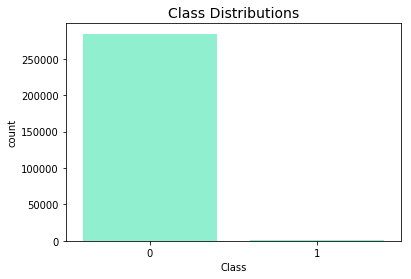

In [10]:
sns.countplot('Class', data=df, color="aquamarine")
plt.title('Class Distributions', fontsize=14)

## 1.3 Split data into 75/25 training & test sets

To prevent information leak, best practice dictates that we should hold out one set of data to test  all the final predictive models against it other. Exploratory data analysis, training and validation should be carried out using only the non-held out data.

I will therefore split the dataset into train and test set (75% vs 25%). The train set can then be split further to include a validation set to tune and optimise the models. This may be in the form of k-fold cross validation for example. 

In [11]:
train,test=train_test_split(df, test_size=0.25, random_state=42, stratify=df['Class'])
# stratify the Class

To keep the same proportion of Fraud/Normal ration in train and test data it is necessary to use the stratify option on the class column. 
Random state has been set so that the random-split can be replicated in the future. 

In [12]:
print("length of training data",len(train))
print("length of normal data",len(train[train["Class"]==0]))
print("length of fraud  data",len(train[train["Class"]==1]))

length of training data 213605
length of normal data 213236
length of fraud  data 369


369 fraud cases out of 492 = 75%

In [13]:
print("length of training data",len(test))
print("length of normal data",len(test[test["Class"]==0]))
print("length of fraud  data",len(test[test["Class"]==1]))

length of training data 71202
length of normal data 71079
length of fraud  data 123


We can see that train contains 213,605 samples and test contains 71202 samples out of a total population of 284,807. 

## 2. Understanding the business problem

So what are we trying to achieve with this dataset? We know that credit card companies have been fighting fraudulent transactions since inception. This is not a new phenomenom. We also know that there are existing strategies in place to combat fraud. Therefore a realistic assumption to make is that the credit card companies want machine learning to augment these existing strategies to improve detection. 

From a overall company perspective the primary objective is to improve profits (revenue) by reducing costs and/or increasing customer spending:

Reduce costs:
- Reduce the cost of fraud on the company's profit margin: better detection rates.
- Reduce the number of manual investigations by staff.

Increase spending:
- Make it easier for customers to spend: reduce rate of declining transactions, reduce the number of times a customer is contacted to provide confirmation of legitimate transactions.

Knowing the objectives above will help guide us on the evaluation metrics for the machine learning models.

## 2.1 How do credit card companies spot and fight fraud?

Let us consider how credit card fraud is currently being tackled.

- In the US, The Fair Credit Billing Act (FCBA) limits consumer liability for unauthorized card transactions to $50. The credit card companies have to cover the remainder. Not completely applicable to European cardholders but useful to know the level that credict card companies will focus on.
- Companies watch individual spending patterns and look for unusual activity. Credit card companies keep track of your spending patterns through systems that determine the validity of your purchases. They know what your usual charging habits are, what towns and regions you typically spend your money in, what stores you frequent, what amounts you tend to charge, and so on. Any time your pattern breaks with highly priced or unusual acquisitions or with transactions done outside your home place, the company notes it and alerts you. The company also notes changed frequency, such as if you logged more transactions than before and if your e-commerce transactions used a changed IP address. Thieves tend to test credit cards by making smaller transactions followed by increasingly larger ones. Credit card companies alert you if they notice such a pattern.
- Companies Use Your Assistance
You may have reported one or more instances of credit card theft. Credit card companies follow up by noting similar charges on one or more of your cards and asking you to verify them. The thief may have engaged in fraud under different names, or other hackers may be perpetrating the same, or similar, swindles.
- Credit card companies use a combination of technology and humanity to fight fraud, employing automated fraud detection algorithms across massive amounts of data collected from millions of customers and hundreds of millions of cards. Once a transaction is flagged as a possible problem, humans can follow up, contacting the customer. Even this is being increasingly automated, with some card holders receiving texts asking them to verify a suspicious transaction on their account.
- Interestingly, when banks or credit card companies detect fraud, they often can see more than just a single unauthorized use of a single card. As the folks at NerdWallet have noted:
Frequent fraud at a given local merchant may suggest employee skimming is going on. Charges that cluster in certain areas may suggest a fraud ring. Another tip-off could be multiple charges from a merchant within a few moments of each other, suggesting the merchant tacked on a second charge the customer may not know about. Yet another big tip in the age of the internet: multiple online charges in close temporal proximity. That suggests a thief got a hold of your card data and went on a spending spree.

It is not clear what existing strategies (filters) have been applied to this dataset but it is very likely to be all those mentioned above. It is also very likely that all the Fraud transactions were labelled manually after further investigation by a team of people. Evidently it is a laborous process and therefore the motivation of releasing this dataset to the Data Science community is to find improvements over existing machine learning models. 

## 2.2 How is spending restricted?

- Credit limit. Each cardholder has a total spending limit imposed on their card. The customer is not allowed to go above this limit without applying for a higher limit. 
- Verified by VISA and MasterCard SecureCode while spending online.
- Verify transaction in real-time automatically using text messages/mobile
- Verify historical transactions over a number of days. (Presumably orders can still be cancelled.)

## 2.3 Strategies that can NOT be used on anonomous data

- Geographical locations - clustering by regions.
    - Online, purchases made from the same IP addresses
       - Purchases cannot be made in different countries or continents (unless if the customer is travelling). 
    - Fraud ring, Within a 40 mile radius
- Dishonest merchants. 
    - Second charges
    - Skimming by merchant employees


- Multiple online charges in close temporal proximity. In order words, many transactions in quick succession (a spending spree).

**Assumptions** 
- Worldline is a French company working in conjunction with the University of Brussels.
- Time Zones: UK GMT, France GMT+1, Eastern Europe GMT+2, Russia GMT+3
- There are fraud detection strategies in place already. This dataset has been provided to assist in ML models with features already transformed using PCA.

- Strategies already in place.
Therefore there is a need for high precision. Capture 100% fraud.
Lower recall is not necessarily a problem. 
These are historical fraud cases have been identified in real-time and after a number of days have passed. The aim is to capture the additional fraud cases not identified using existing strategies.

- With the wider use of chip and pin. These fraud cases will tend to be online purchases.

## 3. Exploratory Data Analysis

Let's remind ourselves of the columns in the dataset.

In [14]:
train.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

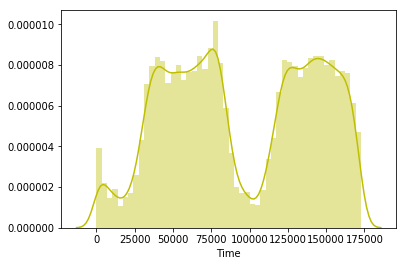

In [15]:
sns.distplot(train['Time'], color="y")

The authors of the dataset states that it contains 2 days worth of transactions therefore:
2 days = 60 seconds multiplied by 60 minutes multiplied by 24 hours multiplied by 2 days = 172,800 seconds

The fraud transactions make up only 0.17% and are not identifiable in the chart above. We should plot this out separately.

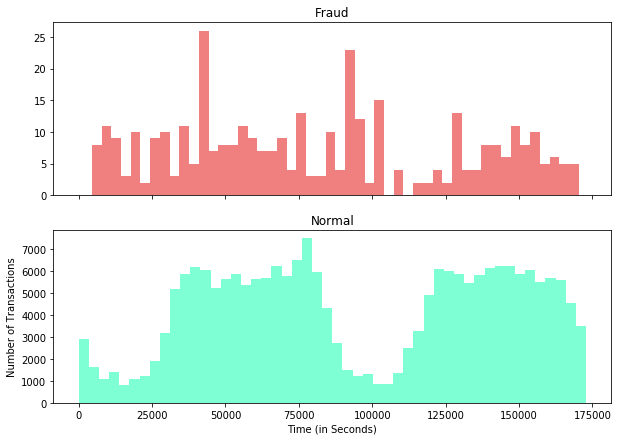

In [16]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,7))
bins = 50

ax1.hist(train.Time[train.Class == 1], color="lightcoral", bins = bins)
ax1.set_title('Fraud')
ax2.hist(train.Time[train.Class == 0], color="aquamarine", bins = bins)
ax2.set_title('Normal')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Number of Transactions')
plt.show()

We can see that there are times during the days when both Fraud and Normal transactions peak.
Let's draw these charts in a different way to see if we can gain further insight.

### 3.1 When do people shop?

We will visualize when people shop and when credit fraud happens and if there is a pattern. For this however we need to convert time from seconds to hours.

In [17]:
def convert_totime(seconds):
    return datetime.datetime.fromtimestamp(seconds);

timeAnalysis = train[['Time', 'Amount', 'Class']].copy()
timeAnalysis['datetime'] = timeAnalysis.Time.apply(convert_totime)

timeAnalysis['hour of the day'] = timeAnalysis.datetime.dt.hour
timeAnalysisGrouped = timeAnalysis.groupby(['Class', 'hour of the day'])['Amount'].count()

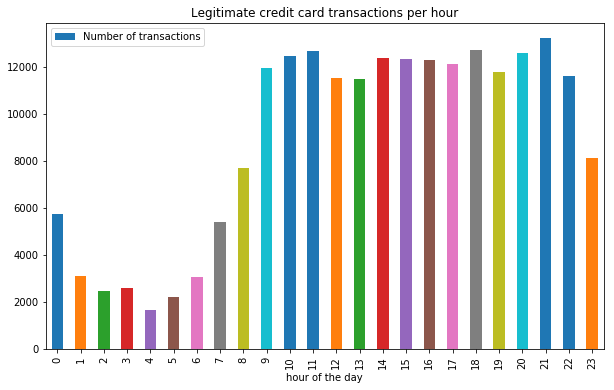

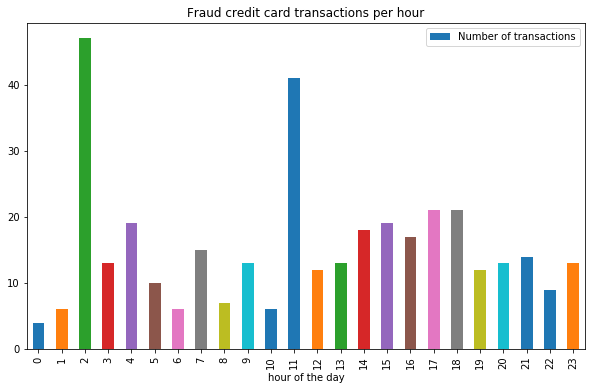

In [18]:
plt.figure(figsize = (10, 6))
validTransactions = timeAnalysisGrouped[0].copy()
validTransactions.name = 'Number of transactions'
validTransactions.plot.bar(title = 'Legitimate credit card transactions per hour', legend = True)

plt.figure(figsize = (10, 6))
fraudTransactions = timeAnalysisGrouped[1].copy()
fraudTransactions.name = 'Number of transactions'
fraudTransactions.plot.bar(title = 'Fraud credit card transactions per hour', legend = True)

### 3.2 Analysis of 'Time'

Normal Transactions:
- We know that the data refers to European credit card holders. The normal transactions seem to align nicely with Greenwich Mean Time. In other words hour 8 seems to correspond to 8am London time.
- Transactions gradually start picking up from 7am to 8am, and from normal office hours at 9am the transaction level remains constant.
- Transactions start dropping off from 11pm and remain low during the night from midnight through to 6am.




Fraud Transactions:
- The first observation we can make is that there are two significant spikes at 2am and 11am. These are the largest.
- The next two large spikes at at 5pm and 6pm.
- If we assume there are existing strategies in place to fight fraud then it is highly unlikely that stolen credit card details of European cardholders can be used in a different continent. Therefore we ignore time zones for moment. 
- Fraudsters choose 2am because it is in the middle of the night. Most business owners an staff have gone to bed. It is past midnight, and a new calendar day to make another purchase from the same seller.
- 5pm and 6pm is towards the end of the working day with everyone finishing work and less inclined to follow-up on fraudulent purchases.
- 11am is harder to understand but could be the busiest for the day and easier to hide fraud transactions. It is also just before lunch time with less staff to investigate unusual activity.

Could the two big spike in Fraud activities be due to time zone differences. If we now assume that transactions can happen using IP addresses not in Europe, then hour 2 and hour 11 could refer to transactions in a pair of countries. Looking at a global time zone map, examples could be San Fransico and Paris, New York and Moscow, London and Tokyo, Brazil and India. There is this possibility but probably unlikely.

### 3.3 How much do people spend?

In section 2.2 we know that there are restrictions on credit card spending. There is a hard stop from the credit limit. Let's see if this is reflected in the data.

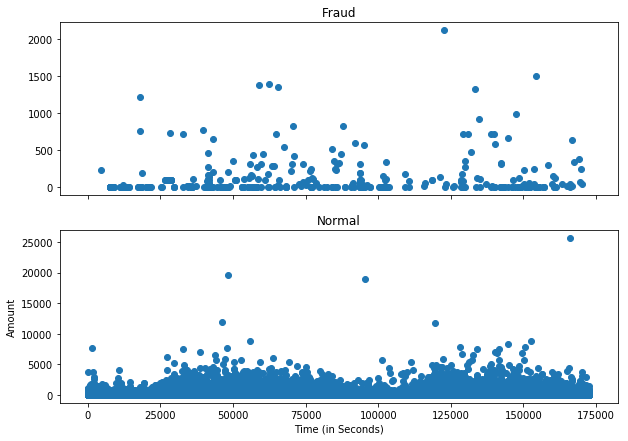

In [19]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,7))

ax1.scatter(train.Time[train.Class == 1], train.Amount[train.Class == 1])
ax1.set_title('Fraud')
ax2.scatter(train.Time[train.Class == 0], train.Amount[train.Class == 0])
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

Normal transactions are concentrated below the 5000 mark. Whereas Fraud transactions have a much smaller amount, typically below 250. This makes sense.

In [20]:
ax2.hist(train.Time[train.Class == 0], bins = bins)
ax2.set_title('Normal')

Text(0.5,1,'Normal')

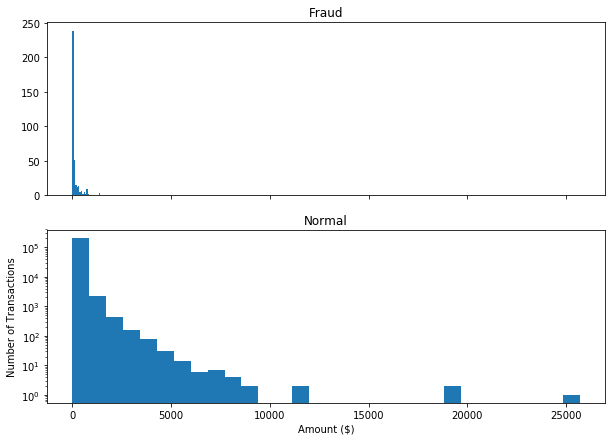

In [21]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,7))
bins = 30

ax1.hist(train.Amount[train.Class == 1], bins = bins)
ax1.set_title('Fraud')
ax2.hist(train.Amount[train.Class == 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

Spending restrictions seem to be working well and only smaller amounts of fraud are going through. Large ticket purchases are being denied.

### 3.4 Analysis of all independant variables together

The simplest and quickest method to understanding all the independant variables is to plot a correlation matrix:
- Green = no correlation
- Blue = positive correlation
- Yellow = negative correlation

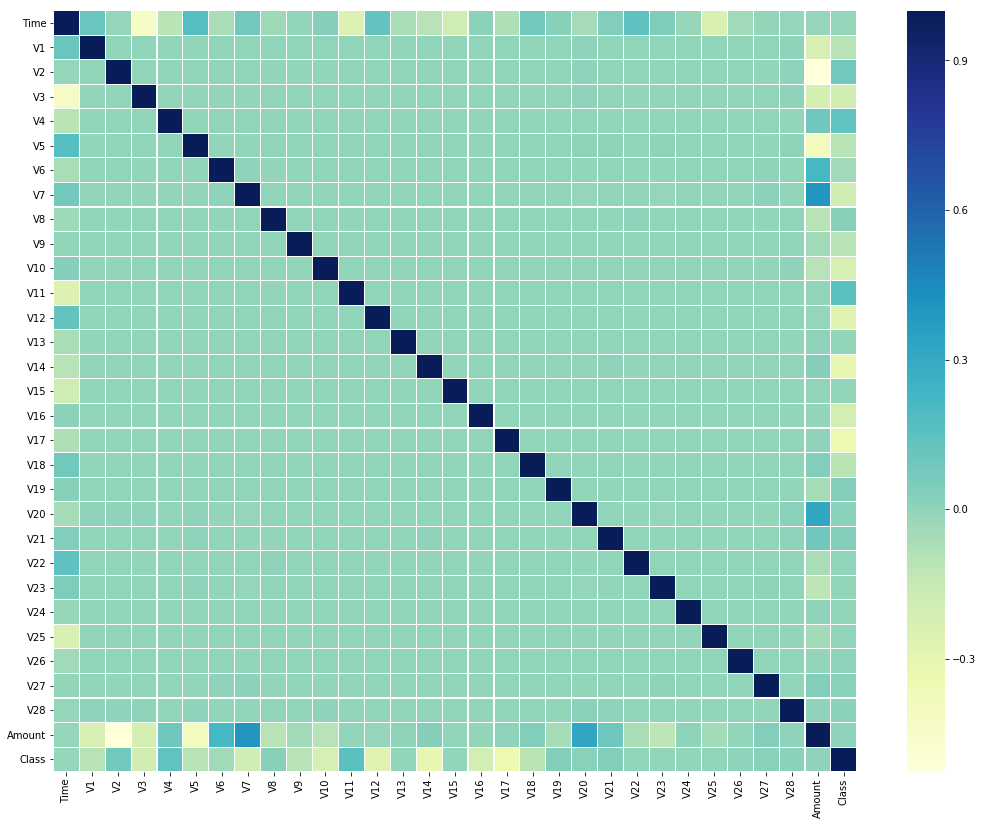

In [22]:
import seaborn as sns
plt.figure(figsize=(18,14))
sns.heatmap(train.corr(), cmap="YlGnBu", linewidths=0.1)

- Class (Fraud or Normal) has high correlation with most of the features V1 to V18. There is little of no correlation with variables V19 to V28. 

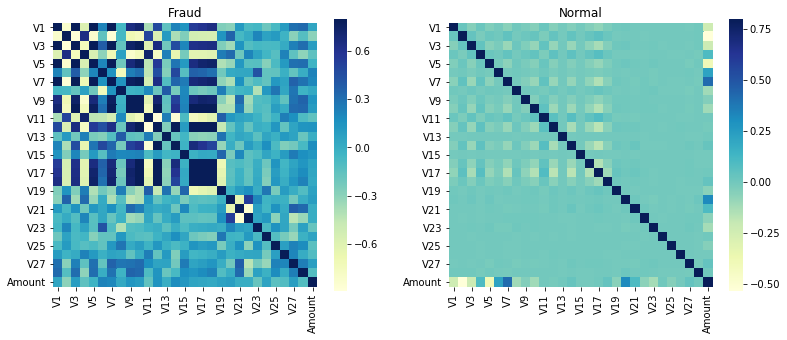

In [23]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(13, 5))
sns.heatmap(train.query("Class==1").drop(['Class','Time'],1).corr(), cmap="YlGnBu", vmax=.8, square=True, ax=ax1)
ax1.set_title('Fraud')
sns.heatmap(train.query("Class==0").drop(['Class','Time'],1).corr(), cmap="YlGnBu", vmax=.8, square=True, ax=ax2);
ax2.set_title('Normal')
plt.show()

- Strong correlations between the all different variables for Fraud data
- Much less correlation for normal data
- Correlation between the data seems to be an important indicator

## 4. Considerations needed when building model

### 4.1 Evaluation Metrics

The data is heavily imbalanced and therefore there is no point in using simple 'accuracy' as the primary metric to evaluate the effectiveness of a predictive model. A simple model that predicts  every transaction as 'normal', and none as 'fraud', will have more than 99% accuracy.

A better way is to distinguish between precision and recall:
- Precision is defined as the number of true positives over the number of true positives plus the number of false positives. In other words out of all the predictions made saying the transactions were fraud TP, how many were predicted correctly TP/(FP+TP).
- Recall is defined as the number of true positives over the number of true positives plus the number of false negatives. In other words, out of all the fraud transactions, how many were predicted correctly TP/(FN+TP).


    Accuracy = TP+TN/Total
    Precison = TP/(TP+FP)
    Recall = TP/(TP+FN)
    TP = True possitive means no of possitve cases which are predicted possitive
    TN = True negative means no of negative cases which are predicted negative
    FP = False possitve means no of negative cases which are predicted possitive
    FN = False Negative means no of possitive cases which are predicted negative

(I will provide interpretation of confusion matrices later when presenting results.)

**The implications of low precision:**
- There will be more false positives
- More transactions will be rejected even though they are normal and legitimate
- More transactions will have to be investigated manually by credit company staff
- More transactions will have to be referred to the clients for verification
- Higher usage of resources to investigate false positives

**The implications of low recall:**
- More Fraud transactions will slip through
- The credit card companies will have to reimburse the clients on more occassions
- High monetary lost

Ideally there should be high precision and high recall. At this stage we cannot say if the business will prefer high precision or high recall. We will need to analyse the results and determine implications later.

Below is a function to visualise a confusion matrix

In [24]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### 4.2 Handling imbalanced data

It seems that learning from imbalanced data has been studied actively for many years within machine learning. It has been the subject of many papers, workshops, special sessions, and dissertations. A vast number of techniques have been tried, with varying results and few clear answers. 

Many data scientists facing this problem for the first time like me have often ask "What should I do when my data is imbalanced?" It seems that there is no definite answer and depends on the data.

That said, here is a rough outline of useful approaches. These are listed approximately in order of effort:

1. Do nothing. Sometimes you get lucky and nothing needs to be done. You can train on the so-called natural (or stratified) distribution and sometimes it works without need for modification.
2. Balance the training set in some way:
    - Undersample the majority class.
    - Oversample the minority class.
    - Synthesize new minority classes.
3. Throw away minority examples and switch to an anomaly detection framework.
4. Modify an existing algorithm to be more sensitive to rare classes.
5. Construct an entirely new algorithm to perform well on imbalanced data.

The approach I will be taking is to first do nothing to the dataset and apply a shuffle and split on the data. If further analysis is required then I will try to balance the dataset. Steps 3-5 are out of scope of this project and may be something to tackle in another project. 

## 5. Approach 1 - Do nothing to imbalanced data

### 5.1 Training the models

Seperate the dependent and independent variables

In [25]:
X= train.iloc[:, train.columns != "Class"].values
y= train.iloc[:, train.columns == "Class"].values

The test set that was split earlier will be held out and only used to test the final model.

In [26]:
X_test= test.iloc[:, test.columns != "Class"].values
y_test= test.iloc[:, test.columns == "Class"].values

Split the data further into training set and validation set. The test set has already been held out. Shuffle and stratify the data.

In [27]:
X_train_im, X_valid, y_train_im, y_valid = train_test_split(X, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

In [28]:
print("The split of the training data is as follows")
print("X_train: ", len(X_train_im))
print("X_valid: ", len(X_valid))
print("y_train: ", len(y_train_im))
print("y_valid: ", len(y_valid))

The split of the training data is as follows
X_train:  170884
X_valid:  42721
y_train:  170884
y_valid:  42721


### 5.2 Support Vector Machines

According to the sciket learn flowchart designed to give users a rough guide on choosing the right estimator, we should first try SVM. 

In [29]:
from sklearn import svm
from sklearn.metrics import classification_report

In [30]:
%%time
clf = svm.SVC(kernel='linear')
clf.fit(X_train_im, y_train_im)
y_pred_im = clf.predict(X_valid)

C:\Users\Cao\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Wall time: 13min 41s


In [31]:
clf.score(X_valid, y_valid)

0.9984316846515765

The accuracy score alone is misleading because just predicting 0 (non-fraud) will give a high score. 

In [32]:
print(classification_report(y_valid,clf.predict(X_valid)))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     42647
          1       0.61      0.27      0.37        74

avg / total       1.00      1.00      1.00     42721



On the Fraud cases there was 61% precision and 27% recall.
A very poor result.
Let's try another model.

In [33]:
# confusion matrix on the validation set.
print(pd.DataFrame(confusion_matrix(y_valid, y_pred_im),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))

     pred_neg  pred_pos
neg     42634        13
pos        54        20


In [34]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_valid, y_pred_im)
np.set_printoptions(precision=2)

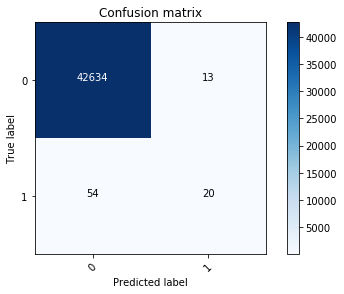

In [35]:
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

### 5.3 Logistic Regression

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [37]:
%%time
# Fitting a simple Logistic Regression
clf = LogisticRegression(C=1.0)
clf.fit(X_train_im, y_train_im)
y_pred_im = clf.predict(X_valid)

C:\Users\Cao\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Wall time: 6.86 s


In [38]:
clf.score(X_valid, y_valid)

0.9989700615622293

In [39]:
print(classification_report(y_valid,clf.predict(X_valid)))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     42647
          1       0.73      0.65      0.69        74

avg / total       1.00      1.00      1.00     42721



On the Fraud cases the was 73% precision and 65% recall.

In [40]:
# confusion matrix on the validation set.
print(pd.DataFrame(confusion_matrix(y_valid, y_pred_im),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))

     pred_neg  pred_pos
neg     42629        18
pos        26        48


In [41]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_valid, y_pred_im)
np.set_printoptions(precision=2)

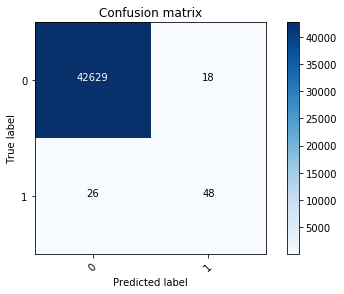

In [42]:
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

Although the results of these two models are poor they will still be useful as quick baseline models. 

### 5.4 Optimising Logistic Regression

We are making the assumption that there are existing strategies already in place to filter out fraud cases. Therefore we want a high recall rate to catch the remaining fraud cases.

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score, accuracy_score, precision_score, f1_score, confusion_matrix


In [44]:
clf = LogisticRegression()

# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.5, 0.7, 0.9, 1]}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

In [45]:
def grid_search_wrapper(refit_score=scorers):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    grid_search = GridSearchCV(clf, log_reg_params, scoring=scorers, refit=refit_score,
                           cv=10, return_train_score=True, n_jobs=2)
    grid_search.fit(X_train_im, y_train_im)

    # make the predictions
    y_pred = grid_search.predict(X_valid)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Logistic Regression optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_valid, y_pred_im),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

#### 5.4a Optimising Precision

In [46]:
grid_search_clf = grid_search_wrapper(refit_score='precision_score')

C:\Users\Cao\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best params for precision_score
{'C': 0.5, 'penalty': 'l1'}

Confusion matrix of Logistic Regression optimized for precision_score on the test data:
     pred_neg  pred_pos
neg     42629        18
pos        26        48


In [47]:
clf = LogisticRegression(C=0.5, penalty='l1')
clf.fit(X_train_im, y_train_im)
y_pred = clf.predict(X_valid)
print(classification_report(y_valid,clf.predict(X_valid)))

C:\Users\Cao\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


             precision    recall  f1-score   support

          0       1.00      1.00      1.00     42647
          1       0.85      0.61      0.71        74

avg / total       1.00      1.00      1.00     42721



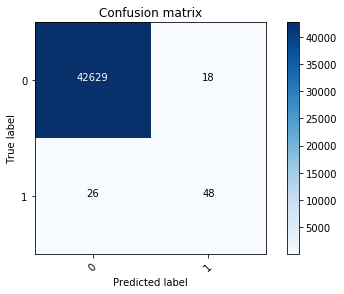

In [48]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_valid, y_pred_im)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

#### 5.4b Optimising Recall

In [49]:
grid_search_clf = grid_search_wrapper(refit_score='recall_score')

C:\Users\Cao\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best params for recall_score
{'C': 0.9, 'penalty': 'l1'}

Confusion matrix of Logistic Regression optimized for recall_score on the test data:
     pred_neg  pred_pos
neg     42629        18
pos        26        48


In [50]:
clf = LogisticRegression(C=0.9, penalty='l1')
clf.fit(X_train_im, y_train_im)
y_pred = clf.predict(X_valid)
print(classification_report(y_valid,clf.predict(X_valid)))

C:\Users\Cao\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


             precision    recall  f1-score   support

          0       1.00      1.00      1.00     42647
          1       0.85      0.61      0.71        74

avg / total       1.00      1.00      1.00     42721



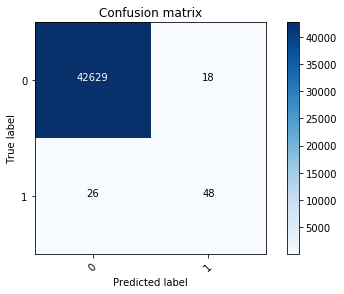

In [51]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_valid, y_pred_im)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

#### 5.4c Optimising F1 score

In [52]:
grid_search_clf = grid_search_wrapper(refit_score='f1_score')

C:\Users\Cao\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best params for f1_score
{'C': 0.7, 'penalty': 'l1'}

Confusion matrix of Logistic Regression optimized for f1_score on the test data:
     pred_neg  pred_pos
neg     42629        18
pos        26        48


Interpretation: 20 cases were correctly predicted as Fraud out of (17+20)=37. In other words recall was 54%.

In [53]:
clf = LogisticRegression(C=0.7, penalty='l1')
clf.fit(X_train_im, y_train_im)
y_pred_im = clf.predict(X_valid)
print(classification_report(y_valid,clf.predict(X_valid)))

C:\Users\Cao\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


             precision    recall  f1-score   support

          0       1.00      1.00      1.00     42647
          1       0.85      0.61      0.71        74

avg / total       1.00      1.00      1.00     42721



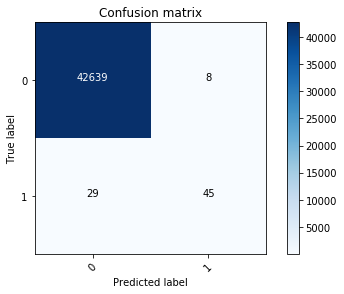

In [54]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_valid, y_pred_im)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

## 6. Approach 2 - Balancing the training set

The first approach to do nothing to the dataset has not yielded sufficient precision and recall. (Please refer back to section 4.2 on ways to handle imbalanced data sets.)

It looks like we will need to balance the training set. There are two ways:
- Undersampling: Taking less samples within the majority class (In our case taking less number of Normal transactions so that our new data will be balanced
- Oversampling: Replicating more samples within the minority class (fraud class) so that we can have a balanced training set
- SMOTE: A type of oversampling where synthetic examples are produced of Minority data and will give as a balanced training set

## 6.1 Undersampling

For undersampling we will take all of the minority class (fraud transactions), and only a portion of majority classs (normal transactions). 

Once we have resampled the data wel will use this resampled data to train and predict.

Let's remind ourselves of the number of fraud transactions in the training set:

In [55]:
Count_Fraud_transaction = len(train[train["Class"]==1]) # fraud by 1
print(Count_Fraud_transaction)

369


Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

In [56]:
# We shuffle the pandas dataframe before creating the subsamples
df = train.sample(frac=1, random_state=42)

# The amount of fraud classes is 369, as determined earlier
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:Count_Fraud_transaction]

In [57]:
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_train = normal_distributed_df.sample(frac=1, random_state=42)

new_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
241254,150949.0,-2.423535,1.659093,-3.071421,2.588033,1.135791,-1.892388,-2.588418,-2.226592,-1.670173,...,-0.934127,0.922038,-0.180255,-0.281719,0.299285,-0.263801,0.150156,0.292112,9.29,1
42700,41204.0,-8.440284,6.147653,-11.683706,6.702780,-8.155839,-3.716264,-12.407313,5.626571,-6.232161,...,2.192855,-0.282597,0.008068,0.403858,-0.018788,0.522722,0.792691,0.067790,30.26,1
102782,68357.0,1.232604,-0.548931,1.087873,0.894082,-1.433055,-0.356797,-0.717492,0.003167,-0.100397,...,-0.448671,-0.517568,0.012833,0.699217,0.527258,-0.322607,0.080805,0.035427,19.59,1
32963,37032.0,1.114834,0.011500,-0.535681,1.546181,2.026440,4.152237,-0.662819,1.027998,-0.346590,...,-0.388373,-1.275871,0.080705,0.957758,0.393668,-0.264207,0.010700,0.031978,48.28,0
27749,34687.0,-0.860827,3.131790,-5.052968,5.420941,-2.494141,-1.811287,-5.479117,1.189472,-3.908206,...,1.192694,0.090356,-0.341881,-0.215924,1.053032,0.271139,1.373300,0.691195,19.02,1


Distribution of the Classes in the subsample dataset
1    0.5
0    0.5
Name: Class, dtype: float64


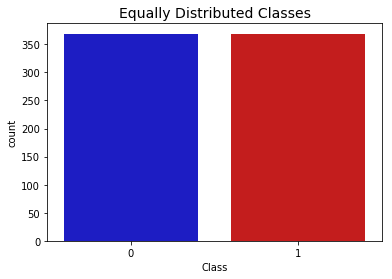

In [58]:
print('Distribution of the Classes in the subsample dataset')
print(new_train['Class'].value_counts()/len(new_train))

colors = ["#0101DF", "#DF0101"]
sns.countplot('Class', data=new_train, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

### 6.1 Training the model - Logistic Regression

In [59]:
X = new_train.drop('Class', axis=1).values
y = new_train['Class'].values

In [60]:
X_train_un, X_valid, y_train_un, y_valid = train_test_split(X, y, 
                                                  stratify=y, 
                                                  random_state=38, 
                                                  test_size=0.1, shuffle=True)

In [61]:
print("The split of the training data is as follows")
print("X_train: ", len(X_train_un))
print("X_valid: ", len(X_valid))
print("y_train: ", len(y_train_un))
print("y_valid: ", len(y_valid))

The split of the training data is as follows
X_train:  664
X_valid:  74
y_train:  664
y_valid:  74


In [62]:
# Classifier Libraries
from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score, accuracy_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

In [63]:
clf = LogisticRegression()

# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.5, 0.7, 0.9, 1]}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

In [64]:
def grid_search_wrapper(refit_score=scorers):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    grid_search = GridSearchCV(clf, log_reg_params, scoring=scorers, refit=refit_score,
                           cv=5, return_train_score=True, n_jobs=2)
    grid_search.fit(X_train_un, y_train_un)

    # make the predictions
    y_pred_un = grid_search.predict(X_valid)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Logistic Regression optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_valid, y_pred_un),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

In [65]:
grid_search_clf = grid_search_wrapper(refit_score='f1_score')

Best params for f1_score
{'C': 0.5, 'penalty': 'l1'}

Confusion matrix of Logistic Regression optimized for f1_score on the test data:
     pred_neg  pred_pos
neg        34         3
pos         4        33


In [66]:
clf = LogisticRegression(C=0.5, penalty='l1')
clf.fit(X_train_un, y_train_un)
y_pred_un = clf.predict(X_valid)
print(classification_report(y_valid,clf.predict(X_valid)))

             precision    recall  f1-score   support

          0       0.89      0.92      0.91        37
          1       0.92      0.89      0.90        37

avg / total       0.91      0.91      0.91        74



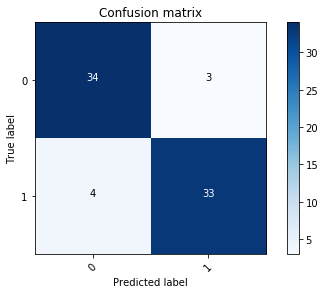

In [67]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_valid, y_pred_un)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

## 7. Oversampling

Oversampling: Replicating more samples within the minority class (fraud class) so that we can have a balanced training set

In [68]:
print("length of training data",len(train))
print("length of normal data",len(train[train["Class"]==0]))
print("length of fraud  data",len(train[train["Class"]==1]))

length of training data 213605
length of normal data 213236
length of fraud  data 369


Split into train and valid sets

In [69]:
OS_train, OS_valid=train_test_split(train,test_size=0.2,random_state=42,stratify=train['Class'])

In [70]:
print("length of training data",len(OS_train))

length of training data 170884


In [71]:
normal_data = OS_train[OS_train["Class"]==0]
print("length of normal data",len(normal_data))
fraud_data = OS_train[OS_train["Class"]==1]
print("length of fraud data",len(fraud_data))

length of normal data 170589
length of fraud data 295


Now start oversampling the training data. Essentially this means duplicating the value of fraud transactions many times over.

In [72]:
# Oversampling. Taking fraud transactions and appending it to the 
# end of normal transactions 578 times.
for i in range (578): # 170589/295=578
    normal_data = normal_data.append(fraud_data)
os_data = normal_data.copy() 

print("length of oversampled data is ",len(os_data))
print("Number of normal transcation in oversampled data",len(os_data[os_data["Class"]==0]))
print("No.of fraud transcation",len(os_data[os_data["Class"]==1]))

length of oversampled data is  341099
Number of normal transcation in oversampled data 170589
No.of fraud transcation 170510


In [73]:
print(round(os_data['Class'].value_counts()[0]/len(os_data) * 100,2), '% of the dataset contains No Frauds')
print(round(os_data['Class'].value_counts()[1]/len(os_data) * 100,2), '% of the dataset contains Frauds')

50.01 % of the dataset contains No Frauds
49.99 % of the dataset contains Frauds


### 7.1 Training the model - Logistic Regression

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score, accuracy_score, precision_score, f1_score, confusion_matrix


In [75]:
X_train_ov = os_data.iloc[:, os_data.columns != "Class"].values
y_train_ov = os_data.iloc[:, os_data.columns == "Class"].values

In [76]:
X_valid= OS_valid.iloc[:, OS_valid.columns != "Class"].values
y_valid= OS_valid.iloc[:, OS_valid.columns == "Class"].values

In [77]:
print("The split of the training data is as follows")
print("X_train: ", len(X_train_ov))
print("X_valid: ", len(X_valid))
print("y_train: ", len(y_train_ov))
print("y_valid: ", len(y_valid))

The split of the training data is as follows
X_train:  341099
X_valid:  42721
y_train:  341099
y_valid:  42721


In [78]:
clf = LogisticRegression()

# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.5, 0.7, 0.9, 1]}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

grid search wrapper function again (delete later)

In [79]:
def grid_search_wrapper(refit_score=scorers):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    grid_search = GridSearchCV(clf, log_reg_params, scoring=scorers, refit=refit_score,
                           cv=10, return_train_score=True, n_jobs=2)
    grid_search.fit(X_train_ov, y_train_ov)

    # make the predictions
    y_pred_ov = grid_search.predict(X_valid)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Logistic Regression optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_valid, y_pred_ov),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

#### 7.1a Optimising F1 score

In [80]:
grid_search_clf = grid_search_wrapper(refit_score='f1_score')

C:\Users\Cao\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best params for f1_score
{'C': 0.5, 'penalty': 'l1'}

Confusion matrix of Logistic Regression optimized for f1_score on the test data:
     pred_neg  pred_pos
neg     41675       972
pos         8        66


In [81]:
clf = LogisticRegression(C=0.5, penalty='l1')
clf.fit(X_train_ov, y_train_ov)
y_pred_ov = clf.predict(X_valid)
print(classification_report(y_valid,clf.predict(X_valid)))

C:\Users\Cao\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


             precision    recall  f1-score   support

          0       1.00      0.98      0.99     42647
          1       0.06      0.89      0.12        74

avg / total       1.00      0.98      0.99     42721



In [82]:
print(pd.DataFrame(confusion_matrix(y_valid, y_pred_ov),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))

     pred_neg  pred_pos
neg     41676       971
pos         8        66


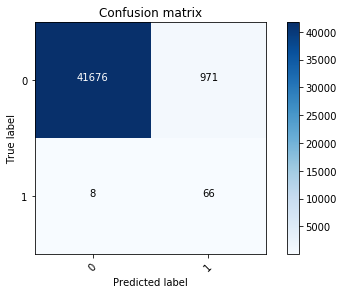

In [83]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_valid, y_pred_ov)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

### 7.2 RandomForest

In [84]:
from sklearn.ensemble import RandomForestClassifier

In [85]:
%%time
clf= RandomForestClassifier(n_estimators=100)
clf.fit(X_train_ov, y_train_ov)
y_pred_ov = clf.predict(X_valid)
print(classification_report(y_valid,clf.predict(X_valid)))

C:\Users\Cao\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


             precision    recall  f1-score   support

          0       1.00      1.00      1.00     42647
          1       0.98      0.72      0.83        74

avg / total       1.00      1.00      1.00     42721

Wall time: 3min 19s


In [86]:
print(pd.DataFrame(confusion_matrix(y_valid, y_pred_ov),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))

     pred_neg  pred_pos
neg     42646         1
pos        21        53


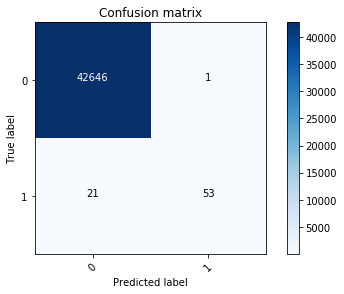

In [87]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_valid, y_pred_ov)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

## 8. SMOTE (Synthetic Minority Oversampling TEchnique)

In [88]:
from imblearn.over_sampling import SMOTE

In [89]:
print("length of training data",len(train))
print("length of normal data",len(train[train["Class"]==0]))
print("length of fraud  data",len(train[train["Class"]==1]))

length of training data 213605
length of normal data 213236
length of fraud  data 369


In [90]:
OS_train, OS_valid=train_test_split(train, test_size=0.2, random_state=42, stratify=train['Class'])

In [91]:
print("length of training data",len(OS_train))

length of training data 170884


In [92]:
normal_data = OS_train[OS_train["Class"]==0]
print("length of normal data",len(normal_data))
fraud_data = OS_train[OS_train["Class"]==1]
print("length of fraud data",len(fraud_data))

length of normal data 170589
length of fraud data 295


In [93]:
data_train_X = OS_train.iloc[:, OS_train.columns != "Class"]
data_train_y = OS_train.iloc[:, OS_train.columns == "Class"]

Create from train set a new data set to obtain a balanced data set using SMOTE

In [94]:
os = SMOTE(ratio='minority', random_state=42)
columns = data_train_X.columns

In [95]:
# now use SMOTE to oversample our train data which have features data_train_X and labels in data_train_y
os_data_X,os_data_y=os.fit_sample(data_train_X,data_train_y)
X_train_sm = pd.DataFrame(data=os_data_X,columns=columns )
y_train_sm = pd.DataFrame(data=os_data_y,columns=["Class"])
# we can Check the numbers of our data
print("length of oversampled data is ",len(X_train_sm))
print("Number of normal transcation in oversampled data",len(y_train_sm[y_train_sm["Class"]==0]))
print("No.of fraud transcation",len(y_train_sm[y_train_sm["Class"]==1]))
print("Proportion of Normal data in oversampled data is ",len(y_train_sm[y_train_sm["Class"]==0])/len(X_train_sm))
print("Proportion of fraud data in oversampled data is ",len(y_train_sm[y_train_sm["Class"]==1])/len(X_train_sm))

C:\Users\Cao\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


length of oversampled data is  341178
Number of normal transcation in oversampled data 170589
No.of fraud transcation 170589
Proportion of Normal data in oversampled data is  0.5
Proportion of fraud data in oversampled data is  0.5


In [96]:
print("The split of the training data is as follows")
print("X_train: ", len(X_train_sm))
print("X_valid: ", len(X_valid))
print("y_train: ", len(y_train_sm))
print("y_valid: ", len(y_valid))

The split of the training data is as follows
X_train:  341178
X_valid:  42721
y_train:  341178
y_valid:  42721


### 8.1 RandomForest

In [97]:
clf= RandomForestClassifier(n_estimators=100)
clf.fit(X_train_sm, y_train_sm)
y_pred_sm = clf.predict(X_valid)
print(classification_report(y_valid,clf.predict(X_valid)))

C:\Users\Cao\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


             precision    recall  f1-score   support

          0       1.00      1.00      1.00     42647
          1       0.89      0.78      0.83        74

avg / total       1.00      1.00      1.00     42721



In [98]:
print(pd.DataFrame(confusion_matrix(y_valid, y_pred_sm),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))

     pred_neg  pred_pos
neg     42640         7
pos        16        58


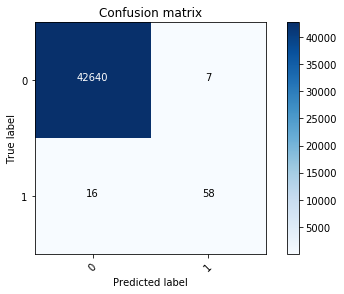

In [99]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_valid, y_pred_sm)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

### 8.2 Logistic Regression

In [115]:
def grid_search_wrapper(refit_score=scorers):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    grid_search = GridSearchCV(clf, log_reg_params, scoring=scorers, refit=refit_score,
                           cv=10, return_train_score=True, n_jobs=2)
    grid_search.fit(X_train_sm, y_train_sm)

    # make the predictions
    y_pred_ov = grid_search.predict(X_valid)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Logistic Regression optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_valid, y_pred_ov),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

In [ ]:
grid_search_clf = grid_search_wrapper(refit_score='f1_score')

In [100]:
clf = LogisticRegression(C=1, penalty='l1')
clf.fit(X_train_sm, y_train_sm)
y_pred_sm = clf.predict(X_valid)
print(classification_report(y_valid,clf.predict(X_valid)))

C:\Users\Cao\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


             precision    recall  f1-score   support

          0       1.00      0.99      0.99     42647
          1       0.11      0.88      0.20        74

avg / total       1.00      0.99      0.99     42721



In [101]:
print(pd.DataFrame(confusion_matrix(y_valid, y_pred_sm),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))

     pred_neg  pred_pos
neg     42124       523
pos         9        65


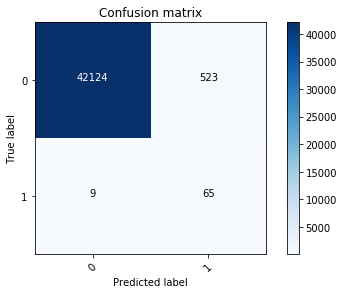

In [102]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_valid, y_pred_sm)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

## 9. Testing All Models (comparing different models using test set)

- **Approach 1** - Do nothing to imbalanced data 
    - Logistic Regression
- **Approach 2** - Balancing the training data
    - Undersampling - Logistic Regression
    - Oversampling - Logistic Regression & Random Forest
    - SMOTE - Random Forest & Logistic Regression

### 9.1 Imbalance data - Logistic Regression

In [103]:
clf = LogisticRegression(C=0.7, penalty='l1')
clf.fit(X_train_im, y_train_im)
y_pred_im = clf.predict(X_test)
print(classification_report(y_test,clf.predict(X_test)))

C:\Users\Cao\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


             precision    recall  f1-score   support

          0       1.00      1.00      1.00     71079
          1       0.85      0.63      0.73       123

avg / total       1.00      1.00      1.00     71202



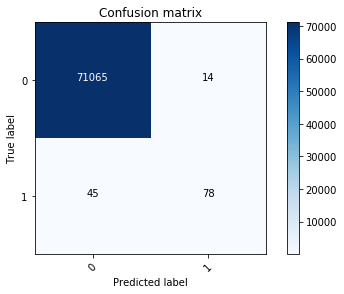

In [104]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_im)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

### 9.2 Undersampling (balanced data) - Logistic Regression

In [105]:
clf = LogisticRegression(C=0.5, penalty='l1')
clf.fit(X_train_un, y_train_un)
y_pred_un = clf.predict(X_test)
print(classification_report(y_test,clf.predict(X_test)))

             precision    recall  f1-score   support

          0       1.00      0.97      0.98     71079
          1       0.04      0.89      0.09       123

avg / total       1.00      0.97      0.98     71202



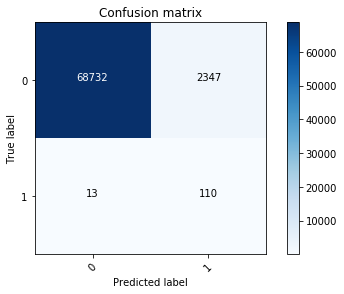

In [106]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_un)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

### 9.3 Oversampling (balanced data) - Logistic Regression

In [107]:
clf = LogisticRegression(C=0.5, penalty='l1')
clf.fit(X_train_ov, y_train_ov)
y_pred_ov = clf.predict(X_test)
print(classification_report(y_test,clf.predict(X_test)))

C:\Users\Cao\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


             precision    recall  f1-score   support

          0       1.00      0.98      0.99     71079
          1       0.07      0.89      0.12       123

avg / total       1.00      0.98      0.99     71202



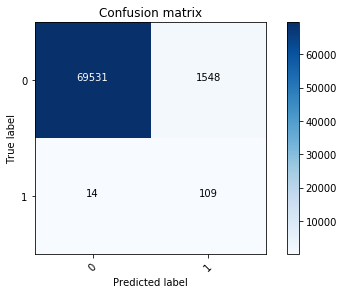

In [108]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_ov)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

### 9.4 Oversampling (balanced data) - RandomForest

In [109]:
clf= RandomForestClassifier(n_estimators=100)
clf.fit(X_train_ov, y_train_ov)
y_pred_ov = clf.predict(X_test)
print(classification_report(y_test,clf.predict(X_test)))

C:\Users\Cao\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


             precision    recall  f1-score   support

          0       1.00      1.00      1.00     71079
          1       0.97      0.75      0.84       123

avg / total       1.00      1.00      1.00     71202



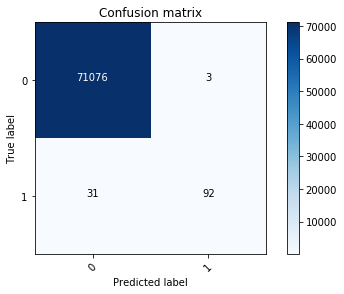

In [110]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_ov)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

### 9.5 SMOTE (balanced data) - Logistic Regression

In [111]:
clf = LogisticRegression(C=0.5, penalty='l1')
clf.fit(X_train_sm, y_train_sm)
y_pred_sm = clf.predict(X_test)
print(classification_report(y_test,clf.predict(X_test)))

C:\Users\Cao\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


             precision    recall  f1-score   support

          0       1.00      0.99      0.99     71079
          1       0.11      0.87      0.20       123

avg / total       1.00      0.99      0.99     71202



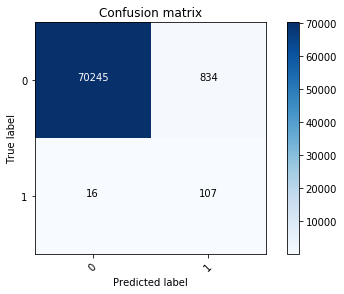

In [112]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_sm)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

### 9.6 SMOTE (balanced data) - Random Forest

In [113]:
clf= RandomForestClassifier(n_estimators=100)
clf.fit(X_train_sm, y_train_sm)
y_pred_sm = clf.predict(X_test)
print(classification_report(y_test,clf.predict(X_test)))

C:\Users\Cao\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


             precision    recall  f1-score   support

          0       1.00      1.00      1.00     71079
          1       0.85      0.80      0.83       123

avg / total       1.00      1.00      1.00     71202



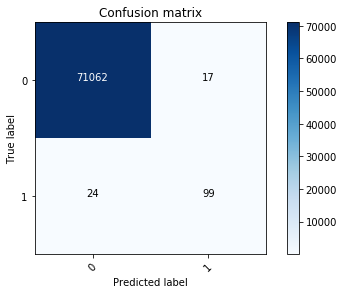

In [114]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_sm)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

### 9.7 Results - ranked in order

Lowest False Positives rate (incorrectly identifying as 'fraud'):
    - 1) 4 = Oversampling - Random Forest
    - 2) 14 = Imbalanced data - Logistic Regression
    - 3) 20 = SMOTE - Random Forest
    - 4) 833 = SMOTE - Logistic Regression
    - 5) 1571 = Oversampling - Logistic Regression
    - 6) 2338 = Undersampling - Logistic Regression    

Lowest number of Fraud transactions missed (false negative):
    - 1) 13 Undersampling - Logistic Regression
    - 2) 14 Oversampling - Logistic Regression
    - 3) 16 SMOTE - Logistic Regression
    - 4) 24 SMOTE - Random Forest
    - 5) 30 Oversampling - Random Forest
    - 6) 45 Imbalanced data - Logistic Regression

### 9.8 Analysis of results

- As expected, there is a trade-off between False positive and False negatives.
- If we try to capture more Fraud activities and reduce the numbers missed, this increases the chances of a normal transaction being flagged up and incorrecly classified as fraudulent.
- Immediately we can rule out the use of predictive models that produce too many False Positives. Rates of 833, 1571, and 2338 are simply too high over a period of 24 hours.
- 813 additional false positives to improve detection rate by 8, SMOTE Logistic Regression vs SMOTE Random Forest.
- 1551 additional false positives to improve detection rate by 10, Oversampling Logistic Regression vs SMOTE Random Forest.
- 2318 additional false positives to improve detection rate by 11, Undersampling Logistic Regression vs SMOTE Random Forest.

- **The best overall model seems to be SMOTE Random Forest, 20 false positives & 24 false negatives.**
- Coming a close second place is Oversampling Random Forest, 4 false positives & 30 false negatives.